<h1>Coronavirus Time Series for New York</h1>
Data link: https://github.com/nytimes/covid-19-data/blob/master/us-states.csv
Last update: 04/10/2020

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

<h2>Data Processing</h2>

In [2]:
# Query for New York State data
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv',parse_dates=['date'],index_col=0, squeeze=True)
df.query("state=='New York'",inplace=True)
df.head()

,state,fips,cases,deaths
date,,,,
2020-03-01,New York,36,1,0
2020-03-02,New York,36,1,0
2020-03-03,New York,36,2,0
2020-03-04,New York,36,11,0
2020-03-05,New York,36,22,0


In [3]:
# Remove unnecessary columns and change data to non-cumulative
df.drop('fips',axis=1,inplace=True)
df.drop('state',axis=1,inplace=True)
df.deaths=df.deaths.diff()           #diff() = for every entry : current - previous
df.cases=df.cases.diff()
df.dropna(inplace=True)
df.head()

,cases,deaths
date,,
2020-03-02,0.0,0.0
2020-03-03,1.0,0.0
2020-03-04,9.0,0.0
2020-03-05,11.0,0.0
2020-03-06,22.0,0.0


In [4]:
dataFrameSize=len(df.index)
trainSize=int(dataFrameSize*.95)

# Split test and train data
train_cases=df.cases[:trainSize]
test_cases=df.cases[trainSize:]
train_deaths=df.deaths[:trainSize]
test_deaths=df.deaths[trainSize:]

<h2>Augmented Dickey Fuller Test to Detect Stationarity</h2>

In [5]:
# Augmented Dickey Fuller Test
    # null hypothesis: data is not stationary
    # if p<.05, reject null hypothesis and assume that the data is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.cases.dropna())
print('p-value for cases: %f' % result[1])
result = adfuller(df.deaths.dropna())
print('p-value for deaths: %f' % result[1])

p-value for cases: 0.969440
p-value for deaths: 0.000000


<h2>Differencing to Reach Stationarity</h2>

/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


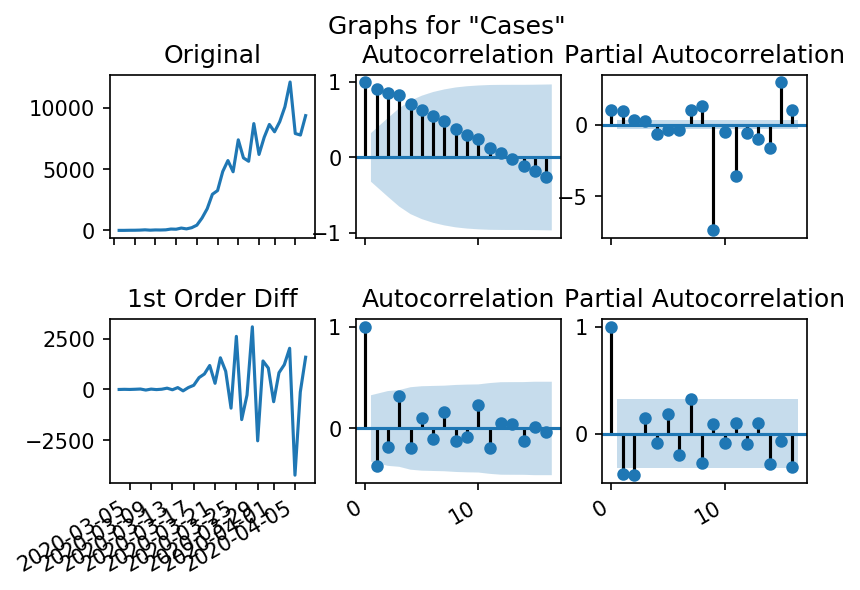

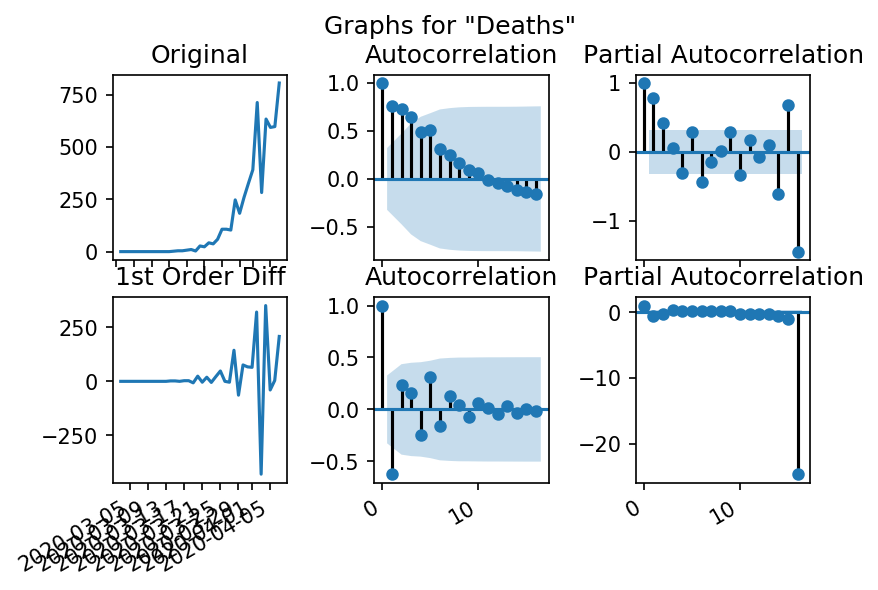

In [6]:
#Differencing for Cases

# Setup
figC, axesC = plt.subplots(2, 3,dpi=150)
figC.suptitle('Graphs for "Cases"')
plt.subplots_adjust(hspace=.5)

# Original 
axesC[0, 0].plot(train_cases); 
axesC[0, 0].set_title('Original')
plot_acf(train_cases, ax=axesC[0, 1])
plot_pacf(train_cases, ax=axesC[0, 2])

# 1st Order Diff
axesC[1, 0].plot(train_cases.diff()); 
axesC[1, 0].set_title('1st Order Diff')
plot_acf(train_cases.diff().dropna(), ax=axesC[1, 1])
plot_pacf(train_cases.diff().dropna(),ax=axesC[1, 2])

figC.autofmt_xdate()


#Possible Differencing for Deaths

# Setup
figD, axesD = plt.subplots(2, 3,dpi=150)
figD.suptitle('Graphs for "Deaths"')
plt.subplots_adjust(wspace=.5)

# Original 
axesD[ 0,0].plot(train_deaths); 
axesD[ 0,0].set_title('Original')
plot_acf(train_deaths, ax=axesD[0,1])
plot_pacf(train_deaths, ax=axesD[0,2])
# 1st Order Diff
axesD[1, 0].plot(train_deaths.diff()); 
axesD[1, 0].set_title('1st Order Diff')
plot_acf(train_deaths.diff().dropna(), ax=axesD[1, 1])
plot_pacf(train_deaths.diff().dropna(),ax=axesD[1, 2])



figD.autofmt_xdate()
plt.show()

<h2>ARIMA Modeling Summary</h2>

In [7]:
# ARIMA modeling for "Cases"
    #if under differenced, add AR (p)
    #if over differenced, add MA (q)


model_C = ARIMA(train_cases, order=(1,1,0))#011
model_C_fit = model_C.fit(disp=False)
print(model_C_fit.summary())
print('\n')

#ARIMA modeling for "Deaths"
model_D = ARIMA(train_deaths, order=(0,1,1))#100 or 011
model_D_fit = model_D.fit()
print(model_D_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.cases   No. Observations:                   36
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -306.045
Method:                       css-mle   S.D. of innovations           1188.313
Date:                Fri, 10 Apr 2020   AIC                            618.090
Time:                        12:00:28   BIC                            622.840
Sample:                    03-03-2020   HQIC                           619.748
                         - 04-07-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           252.4786    145.925      1.730      0.093     -33.529     538.486
ar.L1.D.cases    -0.3677      0.154     -2.382      0.023      -0.670      -0.065
                                    Root

/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<h2>Actual vs Predicted on Given Data</h2>

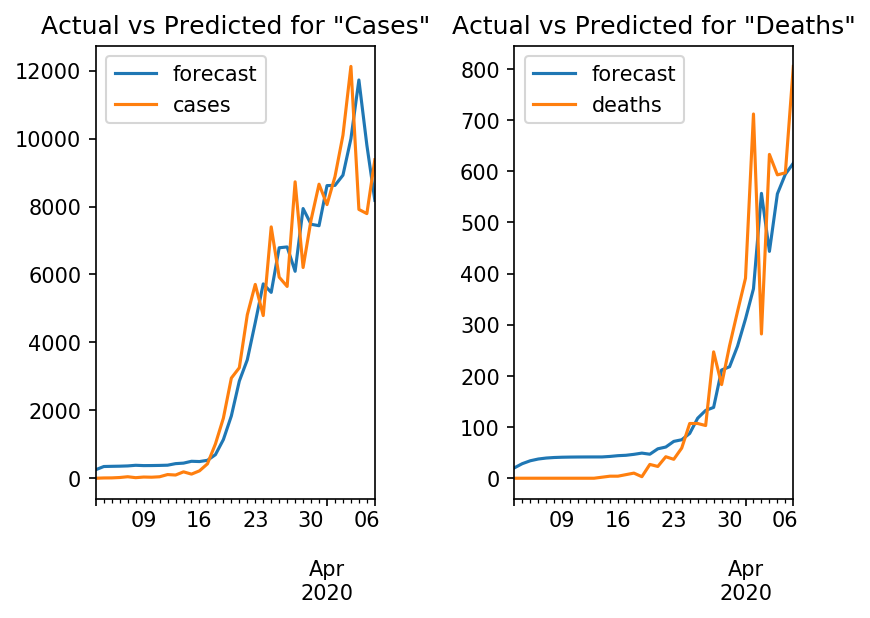

In [8]:
# Actual vs Forecasted
fig, axes = plt.subplots(1,2,dpi=150)
plt.subplots_adjust(wspace=.5)
model_C_fit.plot_predict(alpha=.05,ax=axes[0])
axes[0].set_title('Actual vs Predicted for "Cases"')
model_D_fit.plot_predict(alpha=.05,ax=axes[1])
axes[1].set_title('Actual vs Predicted for "Deaths"')
plt.show()

<h2>Forecasting</h2>

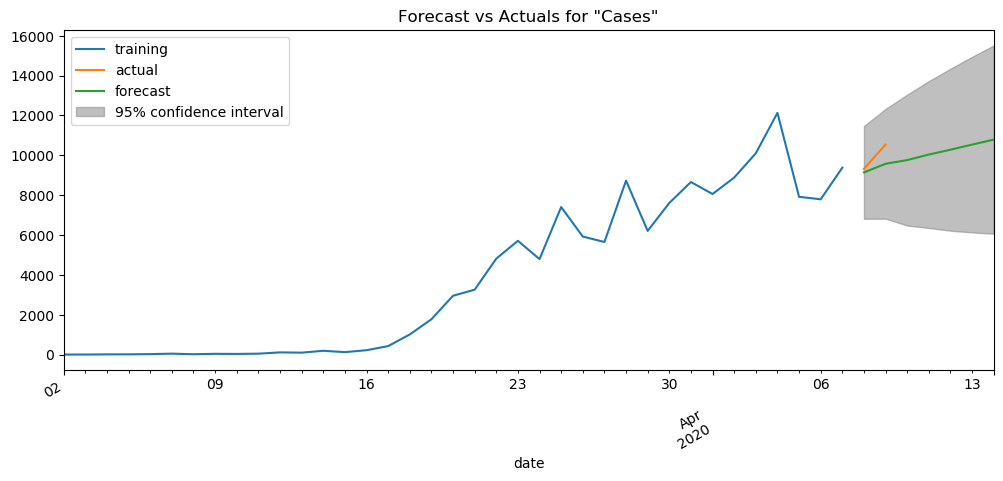

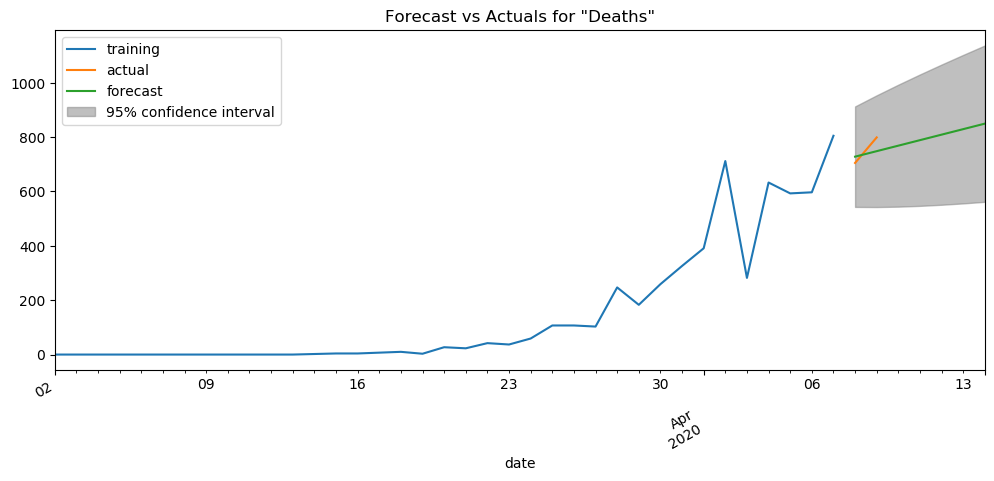

In [9]:
start_index=df.index[trainSize]
end_index='2020-04-14'

# Plot
fig, ax = plt.subplots(figsize=(12,5), dpi=100)

ax=train_cases.plot(ax=ax, label='training')
ax=test_cases.plot(ax=ax,label='actual')
fig=model_C_fit.plot_predict(start=start_index, end=end_index, ax=ax,plot_insample=False,dynamic=False)
plt.title('Forecast vs Actuals for "Cases"')
plt.legend(loc='upper left')

fig.autofmt_xdate()
plt.show()



# Plot
fig, ax = plt.subplots(figsize=(12,5), dpi=100)

ax=train_deaths.plot(ax=ax, label='training')
ax=test_deaths.plot(ax=ax,label='actual')
fig=model_D_fit.plot_predict(start=start_index, end=end_index, ax=ax,plot_insample=False, dynamic=False)
plt.title('Forecast vs Actuals for "Deaths"')
plt.legend(loc='upper left')

fig.autofmt_xdate()
plt.show()